<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Observaciones***

Resuelto.

Solo queda pendiente determinar el mejor modelo para cada receptor






# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [1]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os, sys
from pathlib import Path

# Montar drive
drive.mount('/content/drive')

# Crear carpetas
BASE_DIR = "/content/drive/MyDrive/QSAR/xenotox"
sys.path.append(str(BASE_DIR)) # Necesario para importar qsar.utils
os.makedirs(f"{BASE_DIR}/outputs/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/plots", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/reports", exist_ok=True)

Mounted at /content/drive


In [30]:
# General
import joblib, io
from joblib import Parallel, delayed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings, contextlib, base64
from psutil import cpu_count
from IPython.display import HTML

# Curación y rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize

# Machine Learning
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Balanceo y pipeline general
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from qsar.utils import clean_numeric
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# Hiperoptimización
import optuna
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.base import clone, BaseEstimator, TransformerMixin
from collections import Counter

# Métricas y análisis SHAP
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef, confusion_matrix
    )
import shap

## **2. Configuración**

In [60]:
target_name = 'ahr' # 'ahr', 'pxr', 'car' Los nombres de los archivos deben ser {target_name}_ligands.csv
model_name = 'knn'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = False
use_hyperopt = True  # Método optuna
n_jobs = -1  # Utilizar todos los CPU disponibles
random_state = 42

## **3. Curación de base de datos**

In [5]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles)

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
out_path = f"{BASE_DIR}/ligands/{target_name}_ligands.csv"
df = curate_csv_data(out_path)
display(df.head())


Curación completa: 7485 moléculas válidas (de 7487 iniciales).


,Activity,SMILES
0,Active,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
1,Active,O=C(O)c1cccc(-c2noc(-c3ccccc3F)n2)c1
2,Active,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
3,Active,COc1c2ccoc2cc2oc(=O)ccc12
4,Active,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12


## **4. Cálculo de descriptores**

In [6]:
# 1. Función de cálculo
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return [np.nan] * len(Descriptors._descList)

    results = []

    for _, func in Descriptors._descList:
        try:
            d = func(mol)
            if d is None or isinstance(d, complex):
                d = np.nan
        except Exception:
            d = np.nan

        results.append(d)

    return results

# 2. Configuración de hilos (Ajustado al número real de CPUs disponibles)
n_cores = cpu_count()

print(f"Iniciando cálculo en paralelo con {n_cores} núcleos...")

# 3. Ejecución paralela
smiles_list = df['SMILES'].tolist()
resultados = Parallel(n_jobs=n_cores)(delayed(calcular_descriptores)(s) for s in tqdm(smiles_list, desc="Progreso RDKit"))

# 4. Post-procesamiento y Alineación
# Creamos un Series temporal para usar la lógica de dropna() y mantener índices
desc_series = pd.Series(resultados, index=df.index)
desc_clean = desc_series.dropna()

# 5. Crear X como DataFrame
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc_clean.tolist(), index=desc_clean.index, columns=feature_names)

# 6. Etiquetas y DataFrame original alineados
y = df.loc[desc_clean.index, "Activity"].values
df_curated = df.loc[desc_clean.index].reset_index(drop=True)

# 7. Reporte final
print(f"\nProceso completado.")
print(f"Dataset: {target_name} | Moléculas finales: {len(X)} | Descriptores: {X.shape[1]}")

# Guardar CSV curado
out_path = f"{BASE_DIR}/outputs/reports/{target_name}_ligands_curated.csv"
df_curated.to_csv(out_path, index=False)
print(f"Archivo guardado en: {out_path}")

Iniciando cálculo en paralelo con 2 núcleos...


Progreso RDKit: 100%|██████████| 7485/7485 [01:13<00:00, 101.94it/s]



Proceso completado.
Dataset: ahr | Moléculas finales: 7485 | Descriptores: 217
Archivo guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/reports/ahr_ligands_curated.csv


### 4.1 Visualizar distribución de clases

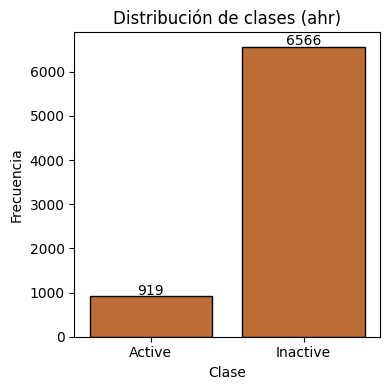

Histograma guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/ahrclass_distribution.png


In [7]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df, edgecolor='black', color='chocolate', legend=False)
plt.title(f"Distribución de clases ({target_name})"), plt.xlabel("Clase"), plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', xytext=(0, -1), textcoords='offset points')

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [8]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=random_state)

# Convertir X_train y X_test a DataFrame para mantener columnas e índices
X_train = pd.DataFrame(X_train, columns=X.columns, index=X.index[X_train.index])
X_test = pd.DataFrame(X_test, columns=X.columns, index=X.index[X_test.index])

## **7. Hiperoptimización Optuna**

In [9]:
# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    counts = Counter(y)
    min_class_count = min(counts.values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# === BUILD PIPELINE ===
def build_pipeline(model, smote_k):
    return Pipeline([
        ("clean", FunctionTransformer(clean_numeric, validate=False)),
        ("imputer", SimpleImputer(strategy="median")),
        ("variance", VarianceThreshold(threshold=0.95)),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("model", model)
    ])

# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X, y_encoded, model_name):

    # Cálculo de smote_k (y_encoded ya debe estar codificado numéricamente)
    min_class = min(Counter(y_encoded).values())
    smote_k = max(1, min(min_class - 1, 5))

    # Selección del modelo base
    if model_name == "xgb":
        base_model = XGBClassifier(eval_metric="logloss", random_state=random_state, n_jobs=n_jobs, tree_method="hist")

    elif model_name == "rf":
        base_model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    elif model_name == "svm":
        base_model = SVC(probability=True, random_state=random_state, kernel='rbf')

    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_jobs=n_jobs)

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Pipeline y validación cruzada
    pipe = build_pipeline(base_model, smote_k)
    cv = safe_stratified_kfold(y_encoded, max_folds=5, random_state=random_state)

    def objective(trial):
        # Definir espacios de búsqueda específicos para cada modelo
        if model_name == "xgb":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.2, log=True),
                "model__subsample": trial.suggest_float("model__subsample", 0.6, 0.9),
                "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 0.9),
                "model__gamma": trial.suggest_float("model__gamma", 0, 0.3),
                "model__min_child_weight": trial.suggest_int("model__min_child_weight", 1, 10),
                "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-5, 1, log=True),
                "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-3, 10, log=True),
            }
        elif model_name == "rf":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 8, 20),
                "model__min_samples_leaf": trial.suggest_int("model__min_samples_leaf", 1, 5),
                "model__min_samples_split": trial.suggest_int("model__min_samples_split", 2, 10),
                "model__max_features": trial.suggest_categorical("model__max_features", ["sqrt", "log2"]),
            }
        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.01, 100, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 1e-5, 1, log=True),
            }
        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 35),
                "model__weights": trial.suggest_categorical("model__weights", ["distance", "uniform"]),
                "model__p": trial.suggest_int("model__p", 1, 2),
            }
        trial_pipe = build_pipeline(clone(base_model), smote_k)
        trial_pipe.set_params(**params)

        # Hacer scorer para cv
        mcc_scorer = make_scorer(matthews_corrcoef)

        scores = cross_val_score(
            trial_pipe,
            X,
            y_encoded,
            scoring=mcc_scorer,
            cv=cv,
            n_jobs=n_jobs
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)) # Detener automaticamente trials malos

    study.optimize(objective, n_trials=30)

    # Entrenar modelo final
    final_pipe = build_pipeline(base_model, smote_k)
    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X, y_encoded)
    # Guardar mejores parámetros y mejor MCC
    final_pipe.best_params_ = study.best_params
    final_pipe.best_score_ = study.best_value

    return final_pipe

In [10]:
# Entrenamiento del StackingClassifier
def train_stacking_model(X_train, y_train_enc, n_jobs=1, random_state=42):

    base_model_names = ["xgb", "rf", "svm", "knn"]
    estimators = []

    print("Entrenando modelos base para stacking:")

    for name in base_model_names:
        print(f"  → Optimizando {name.upper()} con Optuna")
        model_pipe = optimize_model(X_train, y_train_enc, model_name=name)
        estimators.append((name, model_pipe))

    # CV del stacking
    try:
        cv_stack = safe_stratified_kfold(y_train_enc, max_folds=5, random_state=random_state)
    except ValueError:
        cv_stack = 2

    # Meta-modelo
    meta_model = LogisticRegression(
        penalty="l2",
        C=0.1,
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs",
        random_state=random_state
    )

    print("Entrenando StackingClassifier final")

    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        stack_method="predict_proba",
        cv=cv_stack,
        n_jobs=n_jobs,
        passthrough=False
    )

    stacking_model.fit(X_train, y_train_enc)

    return stacking_model

## **8. Entrenamiento y stacking**

In [61]:
# Silenciar warnings innecesarias
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# Detección de tamaño de dataset
min_class = min(Counter(y_train).values()) # y_train aquí es el original sin codificar ni SMOTE
n_splits = min(5, min_class)
do_cv = len(X_train) >= 20 and n_splits >= 2

print(f"Dataset info: Total train = {len(X_train)} | Min class = {min_class} | n_splits = {n_splits}")
if not do_cv:
    print("Dataset pequeño: se omite validación cruzada y se reduce k_neighbors en SMOTE.")

# Codificar etiquetas
global_label_encoder = LabelEncoder()
y_train_enc = global_label_encoder.fit_transform(y_train)   # ["Active","Inactive"] → [0,1]
y_test_enc  = global_label_encoder.transform(y_test)

# ==========================================================
#       ENTRENAMIENTO DEL MODELO
# ==========================================================
if use_stacking:
  print("Entrenando StackingClassifier")
  final_model = train_stacking_model(X_train, y_train_enc)

  # Crear el pipeline de preprocesamiento entrenado (se toma como referencia el primer modelo)
  base_pipeline_ref = final_model.estimators_[0][1]
  trained_preprocessor = Pipeline([
      ("clean", base_pipeline_ref.named_steps["clean"]),
      ("imputer", base_pipeline_ref.named_steps["imputer"]),
      ("variance", base_pipeline_ref.named_steps["variance"]),
      ("scaler", base_pipeline_ref.named_steps["scaler"])
  ])

  # Ajustar el preprocesador a X_train y transformar
  X_train_preprocessed = trained_preprocessor.fit_transform(X_train)

  # Actualizar los nombres de las características después de VarianceThreshold
  mask = trained_preprocessor.named_steps['variance'].get_support()
  final_feature_names = [feature_names[i] for i, val in enumerate(mask) if val]

  model_components = {
      'model': final_model,
      'label_encoder': global_label_encoder,
      'trained_preprocessor': trained_preprocessor,
      'X_train_preprocessed': X_train_preprocessed,
      'y_train': y_train,
      'feature_names': final_feature_names,
      'target_name': target_name,
      'model_type': 'stacking',
      }
  model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_stacking_optuna.pkl"
  joblib.dump(model_components, model_path)
  print(f"Modelo y componentes guardados en: {model_path}")

else:
  print(f"Entrenando modelo {model_name} individual")
  final_model = optimize_model(X_train, y_train_enc, model_name)

  # Crear el pipeline de preprocesamiento entrenado
  trained_preprocessor = Pipeline([
      ("clean", final_model.named_steps["clean"]),
      ("imputer", final_model.named_steps["imputer"]),
      ("variance", final_model.named_steps["variance"]),
      ("scaler", final_model.named_steps["scaler"])
  ])

  # Ajustar el preprocesador a X_train y transformar
  X_train_preprocessed = trained_preprocessor.fit_transform(X_train)

  # Actualizar los nombres de las características después de VarianceThreshold
  mask = trained_preprocessor.named_steps['variance'].get_support()
  final_feature_names = [feature_names[i] for i, val in enumerate(mask) if val]

  # Guardado del modelo entrenado y componentes necesarios / importantes
  model_components = {
      'model': final_model,
      'label_encoder': global_label_encoder,
      'trained_preprocessor': trained_preprocessor,
      'X_train_preprocessed': X_train_preprocessed,
      'y_train': y_train,
      'feature_names': final_feature_names,
      'target_name': target_name,
      'model_type': model_name,
      }
  model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_optuna.pkl"
  joblib.dump(model_components, model_path)
  print(f"Modelo y componentes guardados en: {model_path}")

[I 2026-01-04 22:10:58,966] A new study created in memory with name: no-name-90114f0d-3882-4298-9d39-85458b35c20e


Dataset info: Total train = 5613 | Min class = 689 | n_splits = 5
Entrenando modelo knn individual


[I 2026-01-04 22:11:03,750] Trial 0 finished with value: 0.3555760403225976 and parameters: {'model__n_neighbors': 15, 'model__weights': 'distance', 'model__p': 2}. Best is trial 0 with value: 0.3555760403225976.
[I 2026-01-04 22:11:05,184] Trial 1 finished with value: 0.37138377061225114 and parameters: {'model__n_neighbors': 8, 'model__weights': 'distance', 'model__p': 2}. Best is trial 1 with value: 0.37138377061225114.
[I 2026-01-04 22:11:06,723] Trial 2 finished with value: 0.35947512505507395 and parameters: {'model__n_neighbors': 22, 'model__weights': 'distance', 'model__p': 2}. Best is trial 1 with value: 0.37138377061225114.
[I 2026-01-04 22:11:12,755] Trial 3 finished with value: 0.38954284021038876 and parameters: {'model__n_neighbors': 30, 'model__weights': 'distance', 'model__p': 1}. Best is trial 3 with value: 0.38954284021038876.
[I 2026-01-04 22:11:18,931] Trial 4 finished with value: 0.3922072045873148 and parameters: {'model__n_neighbors': 13, 'model__weights': 'dista

Modelo y componentes guardados en: /content/drive/MyDrive/QSAR/xenotox/outputs/models/best_model_ahr_knn_optuna.pkl


## **9. Métricas y curvas**

In [62]:
# FUNCIÓN DE EVALUACIÓN DEL MODELO, MÉTRICAS Y CURVAS
def compute_metrics(final_model, X_test, y_test, model_name, target_name, label_encoder):

    # === 1. Predicciones ===
    y_pred = final_model.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Bal_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
    }])

    if use_stacking:
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_stacking.csv"
    else:
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"

    metrics_df.to_csv(metrics_path, index=False)
    print(f"Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_pred_labels": y_pred_labels,
        "y_proba": y_proba
    }


In [63]:
# RESULTADOS DE LA EVALUACIÓN
results = compute_metrics(
    final_model=final_model,
    X_test=X_test,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    label_encoder=global_label_encoder
)
print("\nEvaluación completada.")

Métricas guardadas en: /content/drive/MyDrive/QSAR/xenotox/outputs/reports/metrics_ahr_knn.csv


,Model,Target,Accuracy,Bal_Accuracy,Precision,Recall,Specificity,F1_score,MCC
0,knn,ahr,0.819979,0.781478,0.956613,0.832521,0.730435,0.890264,0.434818



Evaluación completada.


## **10. Interpretabilidad SHAP**

SHAP con preprocesamiento antes del análisis y ejecucuión directa sobre el modelo

In [64]:
def process_shap_top20(
    estimator,
    model_name,
    X_proc,
    X_background_proc,
    feature_names,
    target_name,
    max_samples=100,
    top_n=20,
    random_state=42
):

    print(f"--- SHAP Top-{top_n}: {model_name} ---")

    rng = np.random.default_rng(random_state)

    # ===============================
    # Submuestreo
    # ===============================
    n_samples = min(max_samples, X_proc.shape[0])
    idx = rng.choice(X_proc.shape[0], size=n_samples, replace=False)

    X_shap = X_proc[idx]

    # ===============================
    # Selección de explainer
    # ===============================
    model_cls = estimator.__class__.__name__.lower()

    # Tree-based models
    if "xgb" in model_cls or "randomforest" in model_cls:
        explainer = shap.TreeExplainer(
            estimator,
            model_output="raw",
            feature_perturbation="tree_path_dependent"
        )
        shap_values = explainer(X_shap)

    # SVM
    elif "svc" in model_cls or "svm" in model_cls:
        masker = shap.maskers.Independent(
            X_background_proc,
            max_samples=50
        )
        explainer = shap.Explainer(
            estimator.decision_function,  # Especifico para SVM
            masker
        )
        shap_values = explainer(X_shap)

    # KNN
    elif "knn" in model_cls or "neighbors" in model_cls:
        masker = shap.maskers.Independent(
            X_background_proc,
            max_samples=50
        )
        explainer = shap.Explainer(
            estimator.predict_proba,   # OK para clasificación
            masker
        )
        shap_values = explainer(X_shap)

    else:
        raise ValueError(f"Modelo no soportado para SHAP: {estimator.__class__.__name__}")

    # ===============================
    # Extraer SHAP clase positiva
    # ===============================
    values = shap_values.values
    if values.ndim == 3:
        shap_vals = values[:, :, 1]   # clase positiva
    else:
        shap_vals = values

    # ===============================
    # Importancia media absoluta
    # ===============================
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    importance_df = pd.DataFrame({
        "Descriptor": feature_names,
        "Mean_Abs_SHAP": mean_abs_shap
    }).sort_values("Mean_Abs_SHAP", ascending=False)

    top_df = importance_df.head(top_n)
    top_idx = top_df.index.to_numpy()

    # ===============================
    # Plot Top-N and export csv
    # ===============================
    shap.summary_plot(
        shap_vals[:, top_idx],
        X_shap[:, top_idx],
        feature_names=top_df["Descriptor"].values,
        show=True
    )
    shap_path = f"{BASE_DIR}/outputs/plots/shap_{target_name}_{model_name}.png"
    plt.savefig(shap_path, dpi=300, bbox_inches="tight")
    print(f"Gráfico de importancia guardado en: {shap_path}")

    shapcsv_path = f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{model_name}.csv"
    top_df.to_csv(shapcsv_path, index=False)
    print(f"Reporte de importancias guardado en: {shapcsv_path}")


In [65]:
# 1. Preprocessor
preprocessor = Pipeline([
    ("clean", final_model.named_steps["clean"]),
    ("imputer", final_model.named_steps["imputer"]),
    ("variance", final_model.named_steps["variance"]),
    ("scaler", final_model.named_steps["scaler"])
])

# 2. Transform
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# 3. Background
X_background_proc = X_train_proc

# 4. Feature names
var_mask = final_model.named_steps["variance"].get_support()
final_feature_names = X_train.columns[var_mask].to_numpy()

# 5. Sanity checks
assert X_train_proc.shape[1] == len(final_feature_names)


Ejecutando SHAP para knn - ahr
--- SHAP Top-20: knn ---


PermutationExplainer explainer: 101it [55:56, 33.57s/it]
/tmp/ipython-input-581624241.py:91: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


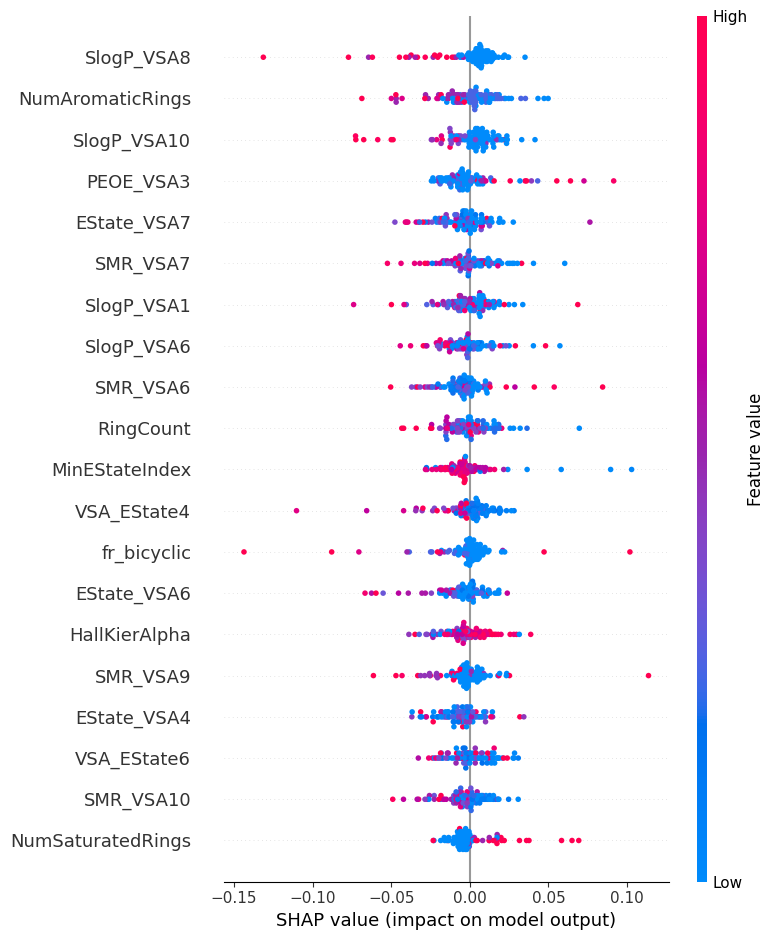

Gráfico de importancia guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/shap_ahr_knn.png
Reporte de importancias guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/shap_importance_ahr_knn.csv


<Figure size 640x480 with 0 Axes>

In [66]:
if use_stacking:
  print(f"Ejecutando SHAP para stacking_metamodel - {target_name}")
  stack_final_estimator = final_model.named_steps["model"].final_estimator_
  process_shap_top20(
      estimator=stack_final_estimator,
      model_name="stacking_metamodel",
      X_proc=X_test_proc,
      X_background_proc=X_train_proc,
      feature_names=final_feature_names,
      target_name="ahr"
      )
else:
  print(f"Ejecutando SHAP para {model_name} - {target_name}")
  process_shap_top20(
      estimator=final_model.named_steps["model"],
      model_name=model_name,
      X_proc=X_test_proc,
      X_background_proc=X_train_proc,
      feature_names=final_feature_names,
      target_name="ahr"
      )

## **11. Y-Scrambling**

In [67]:
scores_scramble = []

for i in tqdm(range(20), desc="Y-Scrambling"):
    # Scramble labels (ya codificadas)
    y_scrambled = np.random.permutation(y_train_enc)

    # Entrenar modelo
    final_model.fit(X_train, y_scrambled)

    # Predicción
    y_pred_scramble = final_model.predict(X_test)

    # Métrica
    mcc = matthews_corrcoef(y_test_enc, y_pred_scramble)
    scores_scramble.append(mcc)

# Resultados
yscramble_results_df = pd.DataFrame({
    "iteration": range(1, 21),
    "MCC": scores_scramble
})

# Guardar
yscramble_path = f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_name}.csv"
yscramble_results_df.to_csv(yscramble_path, index=False)

print(f"Resultados guardados en: {yscramble_path}")
yscramble_results_df

Y-Scrambling: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]

Resultados guardados en: /content/drive/MyDrive/QSAR/xenotox/outputs/reports/yscramble_ahr_knn.csv


,iteration,MCC
0,1,-0.020357
1,2,0.000185
2,3,-0.014029
3,4,0.017548
4,5,-0.033296
5,6,-0.007438
6,7,0.013169
7,8,-0.007182
8,9,0.021905
9,10,0.028922


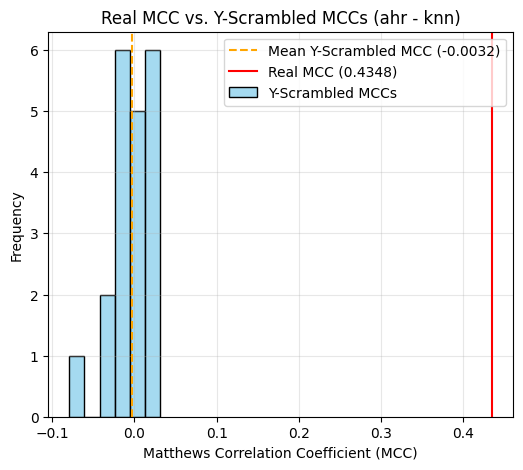

Gráfico de comparación de Y-Scrambling guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/yscramble_ahr_knn.png


In [68]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

# Gráfica

plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})'), plt.xlabel('Matthews Correlation Coefficient (MCC)'), plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = f"{BASE_DIR}/outputs/plots/yscramble_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

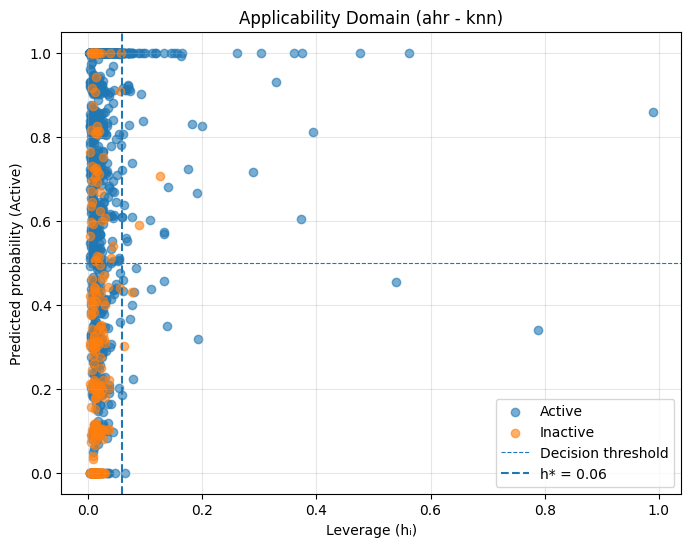

Diagrama de AD guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/ad_ahr_knn.png


In [69]:
# ===============================
# Preprocesamiento (SIN re-entrenar)
# ===============================
preprocessor = Pipeline([
    ("clean", final_model.named_steps['clean']),
    ("imputer", final_model.named_steps['imputer']),
    ("variance", final_model.named_steps['variance']),
    ("scaler", final_model.named_steps['scaler'])
])

X_train_processed_for_ad = preprocessor.transform(X_train)
X_test_processed_for_ad = preprocessor.transform(X_test)

# ===============================
# Leverage calculation
# ===============================
n_train = X_train_processed_for_ad.shape[0]
p = X_train_processed_for_ad.shape[1]

epsilon = 1e-6
XtX_inv = np.linalg.pinv(
    X_train_processed_for_ad.T @ X_train_processed_for_ad +
    epsilon * np.identity(p)
)

# Leverage de TEST respecto a TRAIN
leverage_test = np.sum(
    X_test_processed_for_ad @ XtX_inv * X_test_processed_for_ad,
    axis=1
)

h_star = 3 * (p + 1) / n_train

# ===============================
# Williams Plot (clasificación)
# ===============================
plt.figure(figsize=(8, 6))

active_mask = y_test_enc == 1
inactive_mask = y_test_enc == 0

plt.scatter(
    leverage_test[active_mask],
    results['y_proba'][active_mask],
    alpha=0.6,
    label='Active'
)

plt.scatter(
    leverage_test[inactive_mask],
    results['y_proba'][inactive_mask],
    alpha=0.6,
    label='Inactive'
)

plt.axhline(0.5, linestyle='--', linewidth=0.8, label='Decision threshold')
plt.axvline(h_star, linestyle='--', label=f'h* = {h_star:.2f}')

plt.xlabel('Leverage (hᵢ)')
plt.ylabel('Predicted probability (Active)')
plt.title(f'Applicability Domain ({target_name} - {model_name})')
plt.legend()
plt.grid(alpha=0.3)

plot_path = f"{BASE_DIR}/outputs/plots/ad_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"Diagrama de AD guardado en: {plot_path}")


## **13. Predicción externa**

In [70]:
def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

# ===============================
# Predicción externa desde SMILES
# ===============================
def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            invalid_smiles_list.append(s)
            continue

        try:
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)

            smiles_std = Chem.MolToSmiles(mol)
            descriptors = calcular_descriptores(smiles_std)

            if all(d is not None for d in descriptors):
                processed_data.append(descriptors)
                original_smiles.append(s)
                valid_mols.append(mol)
                molecule_images.append(mol_to_base64_image(mol))
            else:
                invalid_smiles_list.append(s)

        except Exception:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame()

    if processed_data:
        raw_X_ext = np.array(processed_data)

        # ===============================
        # Predicción (pipeline completo)
        # ===============================
        y_proba = final_model.predict_proba(raw_X_ext)[:, 1]
        y_pred_enc = final_model.predict(raw_X_ext)
        y_pred_labels = global_label_encoder.inverse_transform(y_pred_enc)

        # ===============================
        # Dominio de Aplicabilidad
        # ===============================
        X_ext_for_ad = trained_preprocessor.transform(raw_X_ext)

        leverage_ext = np.sum(
            X_ext_for_ad @ XtX_inv * X_ext_for_ad,
            axis=1
        )

        ad_flag = np.where(
            leverage_ext <= h_star,
            'Inside AD',
            'Outside AD'
        )

        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': leverage_ext,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': 'Invalid SMILES or descriptor calculation failed'
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)



--- Predicciones para SMILES válidos ---


,SMILES,Activity_Prediction,Probability,Leverage,AD_Flag,Molecule_Image
0,CC(=O)Nc1ccccc1C,Inactive,1.0,0.003370,Inside AD,
1,c1ccccc1O,Inactive,1.0,0.003018,Inside AD,

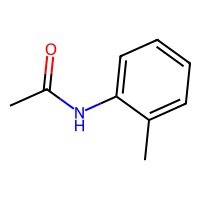
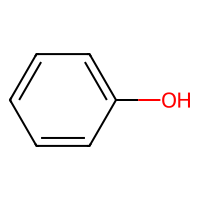


--- SMILES inválidos o con error de cálculo de descriptores ---


,Invalid_SMILES,Reason
0,invalid_smiles_string,Invalid SMILES or descriptor calculation failed
1,1,Invalid SMILES or descriptor calculation failed


In [71]:
# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)

In [72]:
import joblib

# Load the saved model components
model_components = joblib.load(model_path)

# Assign components to individual variables
final_model = model_components['model']
global_label_encoder = model_components['label_encoder']
trained_preprocessor = model_components['trained_preprocessor']
X_train_preprocessed = model_components['X_train_preprocessed']
y_train = model_components['y_train']
final_feature_names = model_components['feature_names']
target_name = model_components['target_name']
model_name = model_components['model_type']

print(f"Modelo y componentes cargados desde: {model_path}")
print(f"Target: {target_name}, Model: {model_name}")
print(f"Número de características después del preprocesamiento: {len(final_feature_names)}")

Modelo y componentes cargados desde: /content/drive/MyDrive/QSAR/xenotox/outputs/models/best_model_ahr_knn_optuna.pkl
Target: ahr, Model: knn
Número de características después del preprocesamiento: 111
